# AN2DL - Homework 2

- Leaderboard nickname: BudaMazzolaMunafo

Team members:
- Alessio Buda
- Dario Mazzola
- Gabriele Munafò



## Imports

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import backend as K
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)

## Auxiliary Functions

The following functions are used to build train and test sequences and to inspect the model's predictions.

In [ ]:
def build_sequences(data, window_size=200, telescope=9, stride=1, pad = 0):
    """
    Creates time windows for a given time series data.

    Parameters:
    - data: numpy array, shape (n_samples,)
        The time series data.
    - window_size: int
        The size of the window.
    - telescope: int
        The number of timestamps to predict into the future.
    - stride: int, optional (default=1)
        The step size between consecutive windows.

    Returns:
    - X: numpy array, shape (n_windows, window_size)
        The input features (windows of data).
    - y: numpy array, shape (n_windows, telescope)
        The target values corresponding to each window.
    """
    n_windows = (len(data) - window_size - telescope) // stride + 1

    if n_windows <= 0:
        # Time series is too short for the specified window size and future steps
        # Pad the time series with zeros at the beginning
        data = np.pad(data, (telescope + window_size - len(data), 0), 'constant', constant_values=pad)
        n_windows = 1
    elif (len(data) < window_size):
        to_add = stride + telescope + 1
        n_windows += 2
        data = np.pad(data, (to_add, 0), 'constant', constant_values=pad)

    X = np.zeros((n_windows, window_size))
    y = np.zeros((n_windows, telescope))

    j = 0

    for i in range(0, n_windows * stride, stride):
        window = data[i:i+window_size]
        # Check if the window is not composed of all zeros
        if not np.all(window == 0):
            X[j, :] = window
            y[j, :] = data[i+window_size:i+window_size+telescope]
            j +=1

    return X[:j], y[:j]

In [ ]:
# Separates the training and test set by taking the time series with valid lenght smaller than the size of the window
def filter_timeseries(data, validity, min_valid_length, max_percentage = 0.1):
  """
  Parameters:
  - data (numpy.ndarray): Input time series data.
  - validity (numpy.ndarray): array specifying the start and end indices of the valid range for each time series.
  - min_valid_length (int): Minimum valid length required for a time series to be considered.
  - max_percentage (float, optional): Maximum percentage of time series to be removed as a fraction. Default is 0.1.

  Returns:
  - Tuple of two numpy.ndarray:
    - Training set: Time series with valid lengths greater than min_valid_length.
    - Test set: Time series with valid lengths less than or equal to min_valid_length.

  The function separates the input time series into training and test sets based on the length of their valid ranges.
  Time series with valid lengths smaller than min_valid_length are moved to the test set, while the remaining ones
  constitute the training set. The removal of time series is limited to a specified maximum percentage.

  Note:
  - The input data and validity arrays should have the same length.
  - The validity array is assumed to have two columns specifying the start and end indices of the valid range.
  """

  # Initialize an empty DataFrame for removed time series
  removed = 0

  max_len = int(len(data) * max_percentage)
  mask = np.full(len(data), True)

  # Iterate through each row in the input DataFrame
  for index in range(len(data)):
      # Find the start and end of the validity range for the current time series
      start_validity = validity[index][0]
      end_validity = validity[index][1]

      # Calculate the length of the valid range for the current time series
      valid_length = end_validity - start_validity + 1

      # Check if the valid length is greater than or equal to the specified minimum
      if removed < max_len and valid_length <= min_valid_length:
          mask[index] = False
          removed += 1

      if removed >= max_len:
          return np.array(data[mask]), np.array(data[~mask])

  return np.array(data[mask]), np.array(data[~mask])

In [ ]:
def build_train_test_datasets(dataset_by_categories, valid_by_categories, window = 200, telescope = 9 , stride = 10, max_percentage = 0.1):
  """
  Parameters:
  - dataset_by_categories (dict): Dictionary where keys represent categories and values are time series data arrays.
  - valid_by_categories (dict): Dictionary mapping categories to arrays specifying the start and end indices of valid ranges for each sequence.
  - window (int, optional): Size of the sliding window for creating sequences. Default is 200.
  - telescope (int, optional): Length of the telescope (future prediction horizon) in building sequences. Default is 9.
  - stride (int, optional): Stride or step size for sliding the window. Default is 10.
  - max_percentage (float, optional): Maximum percentage of time series to be removed as a fraction. Default is 0.1.

  Returns:
  - Tuple of four dictionaries containing training and test sets for each category:
    - X_train: Training set sequences.
    - y_train: Training set labels.
    - X_test: Test set sequences.
    - y_test: Test set labels.

  The function iterates through each category, filters time series based on the valid range, and builds sequences for both
  training and test sets. The filtering is done using the filter_timeseries function, and the sequence building is done
  with the build_sequences function.

  Note:
  - The input datasets should be in the form of dictionaries where keys are categories and values are time series data arrays.
  - The valid_by_categories dictionary should map categories to arrays specifying the start and end indices of valid ranges.
  """

  X_train = {k : [] for k in dataset_by_categories.keys()}

  y_train = {k : [] for k in dataset_by_categories.keys()}

  X_test = {k : [] for k in dataset_by_categories.keys()}

  y_test = {k : [] for k in dataset_by_categories.keys()}

  for k in dataset_by_categories.keys():

      training, testing = filter_timeseries(dataset_by_categories[k], valid_by_categories[k], 200, max_percentage=max_percentage)

      for i, ts in enumerate(training):
          valid_start, valid_end = valid_by_categories[k][i]

          v, l = build_sequences(ts[valid_start:valid_end, 0], window_size=window, stride=stride, telescope=telescope)

          X_train[k].append(v)
          y_train[k].append(l)

      X_train[k] = np.expand_dims(np.concatenate(X_train[k]), axis=2)
      y_train[k] = np.expand_dims(np.concatenate(y_train[k]), axis=2)

      if(max_percentage != 0):

          for i, ts in enumerate(testing):
              valid_start, valid_end = valid_by_categories[k][i]

              v, l = build_sequences(ts[valid_start:valid_end, 0], window_size=window, stride=stride, telescope=telescope)

              X_test[k].append(v)
              y_test[k].append(l)

          X_test[k] = np.expand_dims(np.concatenate(X_test[k]), axis=2)
          y_test[k] = np.expand_dims(np.concatenate(y_test[k]), axis=2)

  return X_train, y_train, X_test, y_test

In [ ]:
def inspect_prediction(X, y, pred, telescope, idx=None):
    """
    Parameters:
    - X (numpy.ndarray): Input sequence for the model.
    - y (numpy.ndarray): True labels for the given input sequence.
    - pred (numpy.ndarray): Model predictions for the given input sequence.
    - telescope (int): Length of the future prediction horizon.
    - idx (int, optional): Index of the sample to inspect. If None, a random index is selected. Default is None.

    The function generates a plot to inspect the predictions for a given sample in the dataset. It compares the true labels (y) and the model predictions (pred).
    The vertical line indicates the end of the given input sequence, and the subsequent points show the true and predicted values for the future prediction horizon.

    Note:
    - The input sequence (X), true labels (y), and model predictions (pred) should be numpy arrays.
    - If idx is not provided, a random index will be chosen for inspection.
    """

    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([X[:,-1],pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1],axis=1),y],axis=1)

    len_samples = len(X[0,:])

    plt.figure(figsize=(12,5))
    plt.axvline(x=len_samples-1, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.plot(np.arange(len_samples), X[idx,:], label = 'Given')
    plt.plot(np.arange(len_samples - 1, len_samples + telescope), y[idx,:], color='orange', label = 'Real')
    plt.plot(np.arange(len_samples - 1, len_samples + telescope), pred[idx,:], color='green', label = 'Predicted')
    plt.legend()
    plt.show()

In [ ]:
def make_predictions_multiple_models(models_to_plot, X_test, y_test):
    """
    Predicts the target variable using multiple pre-trained models and computes evaluation metrics.

    Parameters:
    - models_to_plot: List of dictionaries, each containing information about a pre-trained model,
                     including its path for loading.
    - X_test: Test set features.
    - y_test: True labels for the test set.

    Returns:
    A list of dictionaries with added keys for predictions, mean squared error, and mean absolute error
    for each model.

    """

    # Iterate through each model in the list
    for i in range(len(models_to_plot)):
        # Load the pre-trained model
        model = tfk.models.load_model(models_to_plot[i]['path'])

        # Make predictions on the test set
        predictions = model.predict(X_test, verbose=0)

        # Add predictions to the dictionary for the current model
        models_to_plot[i]['predictions'] = predictions

        # Calculate mean squared error and add it to the dictionary
        mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
        models_to_plot[i]['mean_squared_error'] = mean_squared_error

        # Calculate mean absolute error and add it to the dictionary
        mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
        models_to_plot[i]['mean_absolute_error'] = mean_absolute_error

    # Return the updated list of dictionaries with predictions and evaluation metrics
    return models_to_plot


In [ ]:
def inspect_predictions_multiple_models(models_to_plot, X_test, y_test, telescope, idx=0, last_n_samples=0):
    """
    Visualizes predictions and evaluation metrics for multiple models on a specific test instance.

    Parameters:
    - models_to_plot: List of dictionaries, each containing information about a model's predictions and metrics.
    - X_test: Test set features.
    - y_test: True labels for the test set.
    - telescope: Number of future time steps to visualize.
    - idx: Index of the test instance to visualize. If None, a random index is chosen.
    - last_n_samples: Number of past time steps to visualize. If 0, all past time steps are considered.

    """

    # Randomly select an index if idx is None
    if idx is None:
        idx = np.random.randint(0, len(X_test))

    # Concatenate the target variable with the last feature for visualization
    y = np.concatenate([np.expand_dims(X_test[:, -1], axis=1), y_test], axis=1)

    # Determine the length of samples to visualize
    if last_n_samples == 0:
        len_samples = len(X_test[0, :])
    else:
        len_samples = last_n_samples

    # Plot the given, real, and predicted values
    plt.figure(figsize=(12, 5))
    plt.axvline(x=len_samples - 1, label='Prediction start', alpha=.3, ls='--', color='#5a9aa5')
    plt.plot(np.arange(len_samples), X_test[idx, -last_n_samples:], label='Given')
    plt.plot(np.arange(len_samples - 1, len_samples + telescope), y[idx, -last_n_samples:], label='Real')

    for i in range(len(models_to_plot)):
        pred = models_to_plot[i]['predictions']
        pred = np.concatenate([X_test[:, -1], pred], axis=1)
        plt.plot(np.arange(len_samples - 1, len_samples + telescope), pred[idx, -last_n_samples:], label=models_to_plot[i]['name'])

    plt.legend()
    plt.show()

    # Create a dictionary of metrics for each model
    metrics_values = {
        j['name']: {'MSE': j['mean_squared_error'],
                    'MAE': j['mean_absolute_error']} for j in models_to_plot
    }

    # Print the table header
    print(f"\n| {'Model':<25} | {'MSE':<25} | {'MAE':<25} |")

    # Print a separator line
    print("+---------------------------+---------------------------+---------------------------+")

    # Print each row of the table
    for model, metrics in metrics_values.items():
        print(f"| {model:<25} | {metrics['MSE']:<25} | {metrics['MAE']:<25} |")


In [ ]:
def evaluate_model(history, X_test, y_test):
  """
  Parameters:
  - history (dict): Training history containing loss and metrics values over epochs.
  - X_test (numpy.ndarray): Test set sequences.
  - y_test (numpy.ndarray): True labels for the test set.

  The function generates plots for training and validation loss, training and validation mean absolute error (MAE),
  and learning rate over epochs. It also predicts the test set using the model and calculates and prints the Mean Squared
  Error (MSE) and Mean Absolute Error (MAE) between the true labels and the predicted values.

  Note:
  - The history dictionary should contain keys for 'loss', 'val_loss', 'mean_absolute_error', 'val_mean_absolute_error', and 'lr'.
  - The test set features (X_test) and true labels (y_test) should be numpy arrays.
  """

  best_epoch = np.argmin(history['val_loss'])
  plt.figure(figsize=(17,6))
  plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
  plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
  plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
  plt.title('Mean Squared Error')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()

  plt.figure(figsize=(17,6))
  plt.plot(history['mean_absolute_error'], label='Training MAE', alpha=.8, color='#ff7f0e')
  plt.plot(history['val_mean_absolute_error'], label='Validation MAE', alpha=.9, color='#5a9aa5')
  plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
  plt.title('Mean Absolute Error')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()

  plt.figure(figsize=(18,3))
  plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
  plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()

  # Predict the test set using the model
  predictions = model.predict(X_test, verbose=0)

  # Print the shape of the predictions
  print(f"Predictions shape: {predictions.shape}")

  # Calculate and print Mean Squared Error (MSE)
  mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
  print(f"Mean Squared Error: {mean_squared_error}")

  # Calculate and print Mean Absolute Error (MAE)
  mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
  print(f"Mean Absolute Error: {mean_absolute_error}")

  return predictions

## Models

In [ ]:
# Model using ResNet-style approach
def build_model_ResNet(input_shape, output_shape):
    n_feature_maps = 64

    #block 1
    input_layer = tfkl.Input(shape=(input_shape))
    input_layer = tfkl.Masking(mask_value=0)(input_layer) # set masking value to desired value

    x1 = input_layer
    conv_x = tfkl.Conv1D(n_feature_maps, 8, 1, padding='same')(input_layer)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(n_feature_maps, 5, 1, padding='same')(conv_x)
    conv_y = tfkl.Activation('relu')(conv_y)

    conv_z = tfkl.Conv1D(n_feature_maps, 3, 1, padding='same')(conv_y)

    is_expand_channels = not (input_shape[-1] == n_feature_maps)
    if is_expand_channels:
        x1 = tfkl.Conv1D(n_feature_maps, 1, 1,padding='same')(input_layer)

    #Merging skip connection
    y = tfkl.Add()([x1, conv_z])
    y = tfkl.Activation('relu')(y)

    #block 2
    x1 = y
    conv_x = tfkl.Conv1D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = tfkl.Activation('relu')(conv_y)

    conv_z = tfkl.Conv1D(n_feature_maps*2, 3, 1, padding='same')(conv_y)

    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        x1 = tfkl.Conv1D(n_feature_maps*2, 1, 1,padding='same')(x1)

    #Merging skip connection
    y = tfkl.Add()([x1, conv_z])
    y = tfkl.Activation('relu')(y)

    #block 3
    x1 = y
    conv_x = tfkl.Conv1D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = tfkl.Activation('relu')(conv_y)

    conv_z = tfkl.Conv1D(n_feature_maps*2, 3, 1, padding='same')(conv_y)

    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        x1 = tfkl.Conv1D(n_feature_maps*2, 1, 1,padding='same')(x1)

    #Merging skip connection
    y = tfkl.Add()([x1, conv_z])
    y = tfkl.Activation('relu')(y)

    full = tfkl.Flatten()(y)

    # Classifier
    dropout = tfkl.Dropout(.5, seed=seed)(full)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Dense(output_shape[0], activation = 'relu', name='output_layer')(dropout)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='ResNet-Like_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(), metrics=["mean_squared_error"])

    return model

In [ ]:
def build_CONV_BiLSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this model we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = tfkl.Masking(mask_value=0)(input_layer) # set masking value to desired value

    # Add a Bidirectional LSTM layer with 64 units
    # The Bidirectional LSTM processes the input sequence in both forward and backward directions.
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv1', kernel_initializer='he_normal')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.25)(x)

    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv2', kernel_initializer='he_normal')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.25)(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(1, 2, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_BiLSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(), metrics=["mean_squared_error"])

    return model

In [ ]:
# Fully Connected network
def build_model_FullyConnectedNN(input_shape, output_shape):

    seed = 42  # Set your desired seed value
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    x = tfkl.Masking(mask_value=0)(input_layer) # set masking value to desired value

    x = tfkl.Dense(units=128, kernel_initializer=tf.keras.initializers.HeUniform(seed=seed), name='HiddenDense1')(x)
    x = tfkl.Activation('relu', name='HiddenActivation1')(x)

    x = tfkl.Dense(units=128, kernel_initializer=tf.keras.initializers.HeUniform(seed=seed), name='HiddenDense2')(x)
    x = tfkl.Activation('relu', name='HiddenActivation2')(x)

    # Adjust the units of the output layer to match the target shape (9, 1)
    output_layer = tfkl.Dense(units=output_shape[1], kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed), name='Output')(x)
    output_activation = tfkl.Activation('linear', name='OutputActivation')(output_layer)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_activation.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_activation)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='FullyConnectedNN_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(), metrics=["mean_squared_error"])

    # Return the model
    return model


In [ ]:
# Fully Convolutional network
def build_model_FCNN(input_shape, output_shape):
    assert input_shape[0] >= output_shape[0], "Input time steps should be >= output time steps"

    input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')
    x = tfkl.Masking(mask_value=0)(input_layer) # set masking value to desired value

    # Convolutional layers
    cnn = tfkl.Conv1D(256, 3, padding='causal', activation='relu')(x)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256, 3, padding='causal', activation='relu')(cnn)

    # LSTM layer
    lstm = tfkl.LSTM(80, return_sequences=True)(cnn)

    # Concatenate CNN and LSTM outputs
    combined = tfkl.Concatenate(axis=-1)([cnn, lstm])

    # Flatten the combined output
    flatten = tf.keras.layers.Flatten()(combined)

    # Dense layers for further processing
    dense = tfkl.Dense(128, activation='relu')(flatten)
    dense = tfkl.Dropout(0.2)(dense)

    # Output layer
    output_layer = tfkl.Dense(output_shape[0], activation='linear', name='output_layer')(dense)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='FCNN_model')
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(), metrics=["mean_squared_error"])

    return model


In [ ]:
# Fully Convolutional network with Bidirectional LSTM layer
def build_model_FullyConvolutionalLSTM(input_shape, output_shape):

    input_layer = tfkl.Input(input_shape)
    x = tfkl.Masking(mask_value=1.1)(input_layer)  # Adjust the mask value as needed for your data

    # LSTM layer
    x = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True, activation='relu'))(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(), metrics=["mean_squared_error"])

    return model


In [ ]:
# 1D convolution network
def build_1DCNN_model(input_shape, output_shape):
    assert input_shape[0] >= output_shape[0], "Input time steps should be >= output time steps"

    input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')
    x = tfkl.Masking(mask_value=0)(input_layer) # set masking value to desired value

    cnn = tfkl.Conv1D(256, 3, padding='same', activation='relu')(x)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256, 3, padding='same', activation='relu')(cnn)

    # Flatten the output of the last CNN layer
    flatten = tf.keras.layers.Flatten()(cnn)

    # Dense layer to map to the desired output size
    output_layer = tf.keras.layers.Dense(units=output_shape[0], activation='relu')(flatten)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='1DCNN_model')
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(), metrics=["mean_squared_error"])

    return model

In [ ]:
# 1D convolution network
def build_model_Conv1D_NoCrop(input_shape, output_shape):

    input_layer = tfkl.Input(shape=input_shape, name='Input')
    x = tfkl.Masking(mask_value=0)(input_layer) # set masking value to desired value

    # Feature extractor
    cnn = tfkl.Conv1D(512,7,padding='same',activation='relu')(x)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.1, seed = seed)(cnn)

    cnn = tfkl.Conv1D(512,5,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.1, seed = seed)(cnn)

    cnn = tfkl.Conv1D(512,5,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.1, seed = seed)(cnn)

    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.1, seed=seed)(gap)

    # Flatten the combined output
    flatten = tf.keras.layers.Flatten()(dropout)

    # Dense layers for further processing
    dense = tfkl.Dense(256, activation='relu')(flatten)
    dense = tfkl.Dropout(0.2)(dense)

    # Output layer
    output_layer = tfkl.Dense(output_shape[0], activation='linear', name='output_layer')(dense)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Conv1D_NoCrop_model')
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(), metrics=["mean_squared_error"])

    return model

In [ ]:
# Long Short Term Memory (LSTM) network
def build_model_LSTM_Skip(input_shape, output_shape):

    lstm_n = 64

    input_layer = tfkl.Input(shape=(input_shape))
    input_layer = tfkl.Masking(mask_value=0)(input_layer) # set masking value to desired value


    a = tfkl.Bidirectional(tfkl.LSTM(lstm_n, return_sequences=True))(input_layer)
    x = tfkl.Bidirectional(tfkl.LSTM(lstm_n, return_sequences=True))(a) # main1

    b = tfkl.Add()([a,x]) # main1 + skip1

    x = tfkl.Bidirectional(tfkl.LSTM(lstm_n, return_sequences=True))(b) # main2

    c = tfkl.Add()([b,x]) # main2 + skip2

    x = tfkl.Bidirectional(tfkl.LSTM(lstm_n, return_sequences=False))(c)

    x = tfkl.Flatten()(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Dense(output_shape[0], activation = 'relu', name='output_layer')(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='LSTM-SKIP_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(), metrics=["mean_squared_error"])

    return model

In [ ]:
# Gated Recurrent Unit (GRU) network
def build_model_GRU(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise, we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = tfkl.Masking(mask_value=0)(input_layer) # set masking value to desired value

    # Add a GRU layer with 64 units
    x = tfkl.GRU(256, return_sequences=True, name='gru')(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv1', kernel_initializer='he_normal')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.25)(x)

    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv2', kernel_initializer='he_normal')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.25)(x)

    # Calculate the size to crop from the output to match the output shape
    x = tfkl.Flatten()(x)

    # Classifier
    dropout = tfkl.Dropout(.5, seed=seed)(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Dense(output_shape[0], activation = 'relu', name='output_layer')(dropout)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='GRU_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(), metrics=["mean_squared_error"])

    return model

# Data import and preprocessing

In [ ]:
training_data = np.load('./training_dataset/training_data.npy')
categories = np.load('./training_dataset/categories.npy')
valid_periods = np.load('./training_dataset/valid_periods.npy')

In [ ]:
training_df = pd.DataFrame(training_data)

In [ ]:
# Remove duplicated time series
unique_mask = ~ training_df.duplicated()
training_data = training_data[unique_mask]
valid_periods = valid_periods[unique_mask]
categories = categories[unique_mask]

In [ ]:
training_df = pd.DataFrame(training_data)
valid_periods_df = pd.DataFrame(valid_periods, columns=("start", "end"))
categories_df = pd.DataFrame(categories, columns=("Category",))

In [ ]:
# Convert values to float32 to have a faster training
training_df = training_df.astype(np.float32)
training_data = np.array(training_df)

In [ ]:
training_df.info()
valid_periods_df.info()
categories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47974 entries, 0 to 47973
Columns: 2776 entries, 0 to 2775
dtypes: float32(2776)
memory usage: 508.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47974 entries, 0 to 47973
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   start   47974 non-null  int64
 1   end     47974 non-null  int64
dtypes: int64(2)
memory usage: 749.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47974 entries, 0 to 47973
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  47974 non-null  object
dtypes: object(1)
memory usage: 374.9+ KB


### Sequences of zero values

In [ ]:
# Value to count occurrences
value_to_count = 0

training_df['range'] = valid_periods_df['end'] - valid_periods_df['start']

# Count occurrences in each row
occurrences_per_row = training_df.apply(lambda row: row.value_counts().get(value_to_count, 0) - (2776 - row['range']), axis=1)

# Add a new column to the DataFrame
training_df['occurrences_of_{}'.format(value_to_count)] = occurrences_per_row

In [ ]:
# Display the modified DataFrame
training_df['% of 0'] = training_df['occurrences_of_0'] / training_df['range'] * 100
training_df.sort_values(by='% of 0', ascending=False, inplace=True)

indices = training_df.head(20).index
training_df.head(20)

,0,1,2,3,4,5,6,7,8,9,...,2769,2770,2771,2772,2773,2774,2775,range,occurrences_of_0,% of 0
37022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.597633,0.662722,0.242604,54,43.0,79.629630
28035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.324570,0.324570,0.324570,0.324570,0.324570,0.324570,0.324570,109,79.0,72.477064
45021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.168333,0.156667,0.200000,0.041667,0.333333,0.166667,49,31.0,63.265306
44919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.564103,0.512821,0.564103,0.515385,0.410256,0.359487,0.461538,132,83.0,62.878788
44807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.555556,0.555556,0.575289,0.488889,0.487778,0.445689,0.444444,132,82.0,62.121212
45580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.020000,0.200000,0.200000,0.020000,0.200000,48,22.0,45.833333
21571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,350,155.0,44.285714
47025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.012500,0.218750,0.000000,0.000000,0.500000,0.093750,49,20.0,40.816327
46782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.166667,0.008333,0.166667,0.458333,0.016667,0.833333,49,19.0,38.775510
21572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.700000,0.700000,0.700000,0.700000,0.800000,0.800000,0.800000,350,114.0,32.571429


## Common model parameters

In [ ]:
# Stride and scope may vary depending on the different tests described in the report

test_size = 20
window = 200
stride = 10
telescope = 9
model_to_train = "D" # change this parameter to test models for different categories
index_to_inspect = 1

## Different models for each category

In [ ]:
# Divide the dataset and valid periods based on the time series category
dataset_by_categories = {
    'A' : [],
    'B' : [],
    'C' : [],
    'D' : [],
    'E' : [],
    'F' : [],
}

for category in np.unique(categories):
    dataset_by_categories[category] = np.array(training_data[categories == category])
    dataset_by_categories[category] = np.expand_dims(dataset_by_categories[category], axis=2)

valid_by_categories = {
    'A' : [],
    'B' : [],
    'C' : [],
    'D' : [],
    'E' : [],
    'F' : [],
}

for category in np.unique(categories):
    valid_by_categories[category] = np.array(valid_periods[categories == category])

In [ ]:
X_train, y_train, X_test, y_test = build_train_test_datasets(dataset_by_categories = dataset_by_categories,
                                                             valid_by_categories = valid_by_categories,
                                                             window=window,
                                                             telescope=telescope,
                                                             stride=stride,
                                                             max_percentage=0)

In [ ]:
input_shape = X_train[model_to_train].shape[1:]
output_shape = y_train[model_to_train].shape[1:]
batch_size = 1024
epochs = 200

callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.9, min_lr=1e-5),
]

In [ ]:
# Build model function of the test

model = build_model_LSTM_Skip(input_shape, output_shape)
model.summary()

Model: "LSTM-SKIP_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_4 (Bidirecti  (None, 200, 128)             33792     ['input_4[0][0]']             
 onal)                                                                                            
                                                                                                  
 bidirectional_5 (Bidirecti  (None, 200, 128)             98816     ['bidirectional_4[1][0]']     
 onal)                                                                                            
                                                                                    

In [ ]:
# Training of the model
history_model_by_category = model.fit(
    x = X_train[model_to_train],
    y = y_train[model_to_train],
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = callbacks
).history

In [ ]:
model.save('./Models/LSTM-SKIP_by_category')

In [ ]:
predictions = evaluate_model(history_model_by_category, X_test[model_to_train], y_test[model_to_train])

In [ ]:
inspect_prediction(X_test[model_to_train], y_test[model_to_train], predictions, telescope=telescope)

#Single model

In [ ]:
X_acc = []
y_acc = []

for k in X_train.keys():
  X_acc.append(X_train[k])
  y_acc.append(y_train[k])

X_train_single = np.concatenate(X_acc)
y_train_single = np.concatenate(y_acc)

In [ ]:
input_shape = X_train_single.shape[1:]
output_shape = y_train_single.shape[1:]
batch_size = 1024
epochs = 200

callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.9, min_lr=1e-5),
]

In [ ]:
# Build model function of the test

model = build_model_LSTM_Skip(input_shape, output_shape)
model.summary()

Model: "LSTM-SKIP_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_8 (Bidirecti  (None, 200, 128)             33792     ['input_6[0][0]']             
 onal)                                                                                            
                                                                                                  
 bidirectional_9 (Bidirecti  (None, 200, 128)             98816     ['bidirectional_8[1][0]']     
 onal)                                                                                            
                                                                                    

In [ ]:
# Training of the model
history_model_by_category = model.fit(
    x = X_train_single,
    y = y_train_single,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = callbacks
).history

In [ ]:
model.save('./Models/LSTM-SKIP_single')

In [ ]:
predictions = evaluate_model(history_model_by_category, X_test, y_test)

In [ ]:
inspect_prediction(X_test[model_to_train], y_test[model_to_train], predictions, telescope=telescope)

##Single model taking account of categories

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
def build_model_SingleModel_With_Categories(num_categories, input_shape, output_shape):
    n_feature_maps = 64

    #block 1
    input_layer = tfkl.Input(shape=(input_shape))
    category_input = tfkl.Input(shape=(1,), name='category_input')

    input_layer = tfkl.Masking(mask_value=1.1)(input_layer) # serve mettere 1.1 come padding

    category_embedding = tfkl.Embedding(input_dim=num_categories, output_dim=5, input_length=1)(category_input)
    category_embedding = tfkl.Flatten()(category_embedding)

    x1 = input_layer
    conv_x = tfkl.Conv1D(n_feature_maps, 8, 1, padding='same')(input_layer)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(n_feature_maps, 5, 1, padding='same')(conv_x)
    conv_y = tfkl.Activation('relu')(conv_y)

    conv_z = tfkl.Conv1D(n_feature_maps, 3, 1, padding='same')(conv_y)

    is_expand_channels = not (input_shape[-1] == n_feature_maps)
    if is_expand_channels:
        x1 = tfkl.Conv1D(n_feature_maps, 1, 1,padding='same')(input_layer)

    #Merging skip connection
    y = tfkl.Add()([x1, conv_z])
    y = tfkl.Activation('relu')(y)

    #block 2
    x1 = y
    conv_x = tfkl.Conv1D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = tfkl.Activation('relu')(conv_y)

    conv_z = tfkl.Conv1D(n_feature_maps*2, 3, 1, padding='same')(conv_y)

    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        x1 = tfkl.Conv1D(n_feature_maps*2, 1, 1,padding='same')(x1)

    #Merging skip connection
    y = tfkl.Add()([x1, conv_z])
    y = tfkl.Activation('relu')(y)

    #block 3
    x1 = y
    conv_x = tfkl.Conv1D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = tfkl.Activation('relu')(conv_y)

    conv_z = tfkl.Conv1D(n_feature_maps*2, 3, 1, padding='same')(conv_y)

    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        x1 = tfkl.Conv1D(n_feature_maps*2, 1, 1,padding='same')(x1)

    #Merging skip connection
    y = tfkl.Add()([x1, conv_z])
    y = tfkl.Activation('relu')(y)

    full = tfkl.Flatten()(y)

    # Classifier
    dropout = tfkl.Dropout(.5, seed=seed)(full)

    concatenated = tfkl.Concatenate()([dropout, category_embedding])

    dense_layer = tfkl.Dense(50, activation='relu')(concatenated)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Dense(output_shape[0], activation = 'relu', name='output_layer')(dense_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=[input_layer, category_input], outputs=output_layer, name='SingleModel_With_Categories')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(), metrics=["mean_squared_error"])

    return model

In [ ]:
num_categories = 6

# Initialize a label encoder
label_encoder = LabelEncoder()

# Fit the label encoder to your categories and transform them to integers
categories = label_encoder.fit_transform(categories)

In [ ]:
def filter_timeseries_singlemodel(data, validity, min_valid_length, max_percentage = 0.1):

    # Initialize an empty DataFrame for removed time series
    removed = 0

    max_len = int(len(data) * max_percentage)
    mask = np.full(len(data), True)

    # Iterate through each row in the input DataFrame
    for index in range(len(data)):
        # Find the start and end of the validity range for the current time series
        start_validity = validity[index][0]
        end_validity = validity[index][1]

        # Calculate the length of the valid range for the current time series
        valid_length = end_validity - start_validity + 1

        # Check if the valid length is greater than or equal to the specified minimum
        if removed < max_len and valid_length <= min_valid_length:
            mask[index] = False
            removed += 1

        if removed >= max_len:
            return mask

    return mask

In [ ]:
X_train = []

y_train = []

X_test = []

y_test = []

mask = filter_timeseries_singlemodel(data = training_data, validity = valid_periods, min_valid_length = 200)

training = np.array(training_data[mask])
training_categories = np.array(categories[mask])
training_valid = np.array(valid_periods[mask])

testing = np.array(training_data[~mask])
testing_categories = np.array(categories[~mask])
testing_valid = np.array(valid_periods[~mask])

In [ ]:
total_training_categories = []
total_testing_categories = []
X_train_categories = []
X_test_categories = []

for i, ts in enumerate(training):
    valid_start = training_valid[i][0]
    valid_end = training_valid[i][1]
    to_add = 0

    if((valid_end - valid_start) <= window + telescope):
        to_add = window + telescope + 1 - (valid_end - valid_start)

    v, l = build_sequences(ts[valid_start:valid_end], window=window, stride=stride, telescope=telescope)

    total_training_categories = np.full((v.shape[0], 1), training_categories[i], dtype='int')

    X_train.append(v)
    y_train.append(l)
    X_train_categories.append(total_training_categories)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
total_training_categories = np.concatenate(X_train_categories)

for i, ts in enumerate(testing):
    to_add = 0
    valid_start = testing_valid[i][0]
    valid_end = testing_valid[i][1]

    if((valid_end - valid_start) <= window + telescope):
        to_add = window + telescope + 1 - (valid_end - valid_start)

    v, l = build_sequences(ts[valid_start:valid_end], window=window, stride=stride, telescope=telescope, to_add=to_add)#, debug = debug)

    total_testing_categories = np.full((v.shape[0], 1), training_categories[i], dtype='int')

    X_test.append(v)
    y_test.append(l)
    X_test_categories.append(total_testing_categories)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)
total_testing_categories = np.concatenate(X_test_categories)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 256
epochs = 200

callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.9, min_lr=1e-5)
]

In [ ]:
model = build_model_SingleModel_With_Categories(num_categories = num_categories, input_shape = input_shape, output_shape = output_shape)
model.summary()

In [ ]:
# Training of the model
history_SingleModelWithCategories = model.fit(
    [X_train, total_training_categories], y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = callbacks
).history

In [ ]:
model.save('./Models/SingleModelWithCategories')

In [ ]:
predictions = evaluate_model(history_SingleModelWithCategories, X_test, y_test) ###### CONTROLLA SE GIUSTO: X_test e y_test vanno bene?

In [ ]:
inspect_prediction(X_test[model_to_train], y_test[model_to_train], predictions, telescope=telescope)

## Scalers

### Robust scaler

In [ ]:
from sklearn.preprocessing import RobustScaler

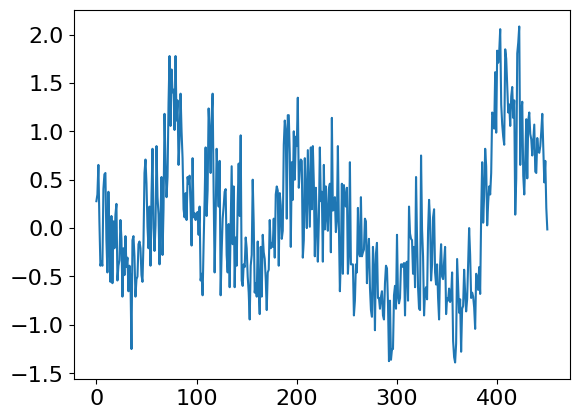

In [ ]:
# for comparation porpuses
data = dataset_by_categories[model_to_train][index_to_inspect]

valid_start, valid_end = valid_by_categories[model_to_train][index_to_inspect]

# Apply RobustScaler to data
scaler = RobustScaler()
x_scaled = scaler.fit_transform(data[valid_start:valid_end].reshape(-1, 1))

x_scaled = x_scaled.reshape(1, -1)[0]
x_scaled = np.expand_dims(x_scaled, axis=1)
data[valid_start:valid_end] = x_scaled

plt.plot(data[valid_start:valid_end])

In [ ]:
X_train = {
    'A' : [],
    'B' : [],
    'C' : [],
    'D' : [],
    'E' : [],
    'F' : [],
}

y_train = {
    'A' : [],
    'B' : [],
    'C' : [],
    'D' : [],
    'E' : [],
    'F' : [],
}

X_test = {
    'A' : [],
    'B' : [],
    'C' : [],
    'D' : [],
    'E' : [],
    'F' : [],
}

y_test = {
    'A' : [],
    'B' : [],
    'C' : [],
    'D' : [],
    'E' : [],
    'F' : [],
}

medians_test = []
IQRs_test = []
max_percentage = .1

X_train = {k : [] for k in dataset_by_categories.keys()}

y_train = {k : [] for k in dataset_by_categories.keys()}

X_test = {k : [] for k in dataset_by_categories.keys()}

y_test = {k : [] for k in dataset_by_categories.keys()}

for k in dataset_by_categories.keys():

    training, testing = filter_timeseries(dataset_by_categories[k], valid_by_categories[k], 200, max_percentage=max_percentage)

    for i, ts in enumerate(training):
        valid_start, valid_end = valid_by_categories[k][i]

        # Apply RobustScaler to data
        scaler = RobustScaler()
        x_scaled = scaler.fit_transform(ts[valid_start:valid_end].reshape(-1, 1))
        x_scaled = x_scaled.reshape(1, -1)[0]
        x_scaled = np.expand_dims(x_scaled, axis=1)
        ts[valid_start:valid_end] = x_scaled

        v, l = build_sequences(ts[valid_start:valid_end, 0], window_size=window, stride=stride, telescope=telescope)

        X_train[k].append(v)
        y_train[k].append(l)

    X_train[k] = np.expand_dims(np.concatenate(X_train[k]), axis=2)
    y_train[k] = np.expand_dims(np.concatenate(y_train[k]), axis=2)

    if(max_percentage != 0):

        for i, ts in enumerate(testing):
            valid_start, valid_end = valid_by_categories[k][i]

            # Apply RobustScaler to data
            scaler = RobustScaler()
            x_scaled = scaler.fit_transform(ts[valid_start:valid_end].reshape(-1, 1))
            x_scaled = x_scaled.reshape(1, -1)[0]
            x_scaled = np.expand_dims(x_scaled, axis=1)
            ts[valid_start:valid_end] = x_scaled

            # Store medians and interquartile ranges of test dataset (to scale back results)
            medians_test.append(scaler.center_[0])
            IQRs_test.append(scaler.scale_[0])

            v, l = build_sequences(ts[valid_start:valid_end, 0], window_size=window, stride=stride, telescope=telescope)

            X_test[k].append(v)
            y_test[k].append(l)

        X_test[k] = np.expand_dims(np.concatenate(X_test[k]), axis=2)
        y_test[k] = np.expand_dims(np.concatenate(y_test[k]), axis=2)

In [ ]:
input_shape = X_train[model_to_train].shape[1:]
output_shape = y_train[model_to_train].shape[1:]
batch_size = 1024
epochs = 200

callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.9, min_lr=1e-5),
]

In [ ]:
model = build_model_LSTM_Skip(input_shape, output_shape)
model.summary()

Model: "LSTM-SKIP_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_12 (Bidirect  (None, 200, 128)             33792     ['input_8[0][0]']             
 ional)                                                                                           
                                                                                                  
 bidirectional_13 (Bidirect  (None, 200, 128)             98816     ['bidirectional_12[1][0]']    
 ional)                                                                                           
                                                                                    

In [ ]:
history_robust = model.fit(
    x = X_train[model_to_train],
    y = y_train[model_to_train],
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = callbacks
).history

In [ ]:
model.save('./Models/Robust')

In [ ]:
predictions = evaluate_model(history_robust, X_test[model_to_train], y_test[model_to_train])

In [ ]:
inspect_prediction(X_test[model_to_train], y_test[model_to_train], predictions, telescope=telescope)

##Repetition of sequences

In [ ]:
# NOTE: the repetition of sequence for sequences shorter than (window + telescope) has been tested on a previous version of the build sequence function (below).
# Although correct, this function is not fully optimized and may sometimes add more padding than needed. Because of this the function was later re-written.

def build_sequences_repeat(d, window=200, stride=20, telescope=100, to_add = 0, debug = False):
    # Sanity check to avoid runtime errors

    assert window % stride == 0
    dataset = []
    labels = []

    temp_df = d.copy()
    temp_label = d.copy()

    if(to_add != 0):

      desired_len = len(temp_df) + to_add
      # Calculate the number of copies needed to reach or exceed the desired length
      num_copies = -(-desired_len // np.shape(temp_df)[0])

      # Use numpy.tile to create a new array by repeating the original array
      temp_df = np.tile(temp_df, (num_copies, 1))
      temp_df = temp_df[len(temp_df)-desired_len:]
      temp_label = np.tile(temp_label, (num_copies, 1))
      temp_label = temp_label[len(temp_label)-desired_len:]

    padding_check = len(temp_df) % window

    # Add padding if needed
    if(padding_check != 0 and to_add == 0):
      # Compute padding length
      padding_len = window - len(temp_df)%window

      pad = 0

      # Concatenate the padding to df
      padding = np.full((padding_len, temp_df.shape[1]), pad, dtype='float32')
      temp_df = np.concatenate((padding,temp_df))


      # Concatenate the padding to labels
      padding = np.full((padding_len, temp_label.shape[1]), pad, dtype='float32')
      temp_label = np.concatenate((padding,temp_label))
      assert len(temp_df) % window == 0

    # Build window + telescope pair
    for idx in np.arange(start=1, stop=len(temp_df)-window-telescope+1, step=stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    # Turn pandas df into NumPy arrays
    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels

In [ ]:
X_train = {
    'A' : [],
    'B' : [],
    'C' : [],
    'D' : [],
    'E' : [],
    'F' : [],
}

y_train = {
    'A' : [],
    'B' : [],
    'C' : [],
    'D' : [],
    'E' : [],
    'F' : [],
}

X_test = {
    'A' : [],
    'B' : [],
    'C' : [],
    'D' : [],
    'E' : [],
    'F' : [],
}

y_test = {
    'A' : [],
    'B' : [],
    'C' : [],
    'D' : [],
    'E' : [],
    'F' : [],
}

for k in dataset_by_categories.keys():

  # Perfrom train - test split
  training, testing = filter_timeseries(dataset_by_categories[k], valid_by_categories[k], 200)

  # Training set
  for i, ts in enumerate(training):
    valid_start = valid_by_categories[k][i][0]
    valid_end = valid_by_categories[k][i][1]
    seq_len = valid_end - valid_start

    to_add = 0

    # Compute padding needed to reach window + telescope length (sequence shorter than window + telescope)
    if(seq_len <= window + telescope):
        to_add = window + telescope + 1 - seq_len

    v, l = build_sequences_repeat(ts[valid_start:valid_end], window=window, stride=stride, telescope=telescope, to_add=to_add)

    X_train[k].append(v)
    y_train[k].append(l)

  X_train[k] = np.concatenate(X_train[k])
  y_train[k] = np.concatenate(y_train[k])

  # Testing set
  for i, ts in enumerate(testing):
    valid_start = valid_by_categories[k][i][0]
    valid_end = valid_by_categories[k][i][1]
    seq_len = valid_end - valid_start

    to_add = 0

    # Compute padding needed to reach window + telescope length (sequence shorter than window + telescope)
    if(seq_len <= window + telescope):
        to_add = window + telescope + 1 - (valid_end - valid_start)

    v, l = build_sequences_repeat(ts[valid_start:valid_end], window=window, stride=stride, telescope=telescope, to_add=to_add)

    X_test[k].append(v)
    y_test[k].append(l)

  X_test[k] = np.concatenate(X_test[k])
  y_test[k] = np.concatenate(y_test[k])

In [ ]:
input_shape = X_train[model_to_train].shape[1:]
output_shape = y_train[model_to_train].shape[1:]
batch_size = 1024
epochs = 200

callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.9, min_lr=1e-5),
]

Model: "LSTM-SKIP_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_4 (Bidirecti  (None, 200, 128)             33792     ['input_4[0][0]']             
 onal)                                                                                            
                                                                                                  
 bidirectional_5 (Bidirecti  (None, 200, 128)             98816     ['bidirectional_4[1][0]']     
 onal)                                                                                            
                                                                                    

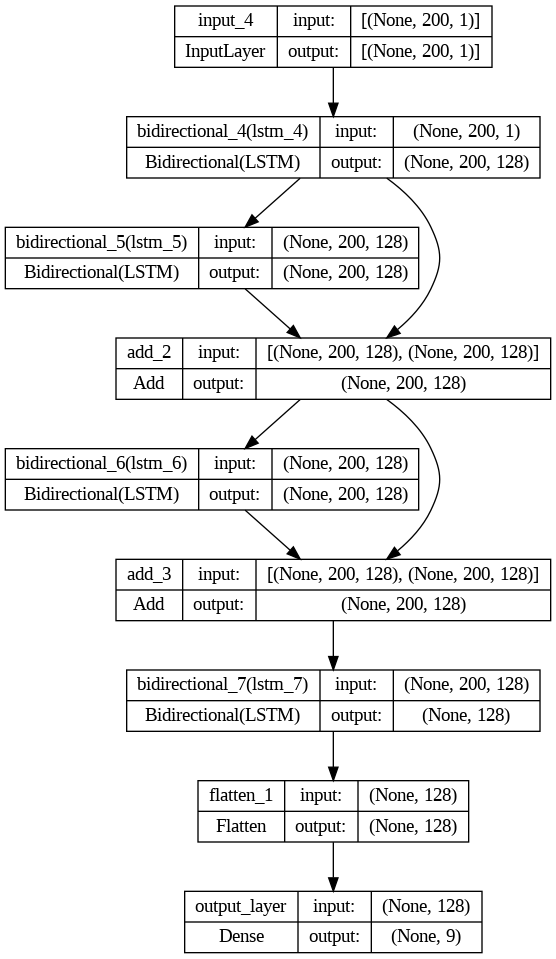

In [ ]:
model = build_model_LSTM_Skip(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history_repeat = model.fit(
    x = X_train[model_to_train],
    y = y_train[model_to_train],
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = callbacks
).history

In [ ]:
model.save('./Models/LSTM-SKIP_model_repeat')

In [ ]:
predictions = evaluate_model(history_repeat, X_test[model_to_train], y_test[model_to_train])

In [ ]:
inspect_prediction(X_test[model_to_train], y_test[model_to_train], predictions, telescope=telescope)

##Autocorrelation

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf

In [ ]:
# Check if time series is stationary
def check_stationarity(series):
    result = adfuller(series)
    if result[1] < 0.05:
        True
    else:
        False

In [ ]:
# Function to apply differencing and check stationarity
def apply_differencing_and_check_stationarity(timeseries):
    # Apply first differencing
    num_diffs = 0
    timeseries = pd.DataFrame(timeseries)
    timeseries = timeseries.dropna()

    while not check_stationarity(timeseries) and len(timeseries) > 0:
        timeseries = timeseries.replace([np.inf, -np.inf], np.nan).dropna() # Drop NaN and inf values created by differencing
        num_diffs += 1

    nlags_value = len(timeseries)/3
    # Calculate ACF and Confidence Intervals
    lag_acf = acf(timeseries, nlags=nlags_value, alpha=0.05)
    acf_values = lag_acf[0]
    conf_intervals = lag_acf[1]

    # Identify the cut-off point where ACF values are not significantly different from zero
    for i in range(len(acf_values)):
        lower_ci = conf_intervals[i][0]
        upper_ci = conf_intervals[i][1]
        if acf_values[i] < upper_ci and acf_values[i] > lower_ci:
            cut_off_point = i
            break

    return cut_off_point, num_diffs, timeseries

In [ ]:
def reverse_differencing(differenced_series, original_series, num_diffs):
    """
    Reverse the differencing of a time series.

    :param differenced_series: Pandas Series that has been differenced
    :param original_series: The original Pandas Series (before differencing)
    :param num_diffs: The number of times differencing was applied
    :return: Pandas Series after reversing the differencing
    """
    # Starting value before differencing was applied
    #starting_value = original_series.iloc[0]

    starting_value = original_series

    for _ in range(num_diffs):
        differenced_series = differenced_series.cumsum() + starting_value

    return differenced_series

In [ ]:
cropped_dataset_by_categories = dataset_by_categories.copy()

cropped_valid_by_categories = valid_by_categories.copy()

In [ ]:
num_diff = []

for k in cropped_dataset_by_categories.keys():
    for i in range(len(cropped_dataset_by_categories[k])):
        start = cropped_valid_by_categories[k][i][0]
        end = cropped_valid_by_categories[k][i][1]

        ############################## Non funziona, capire perché!!! ##############################

        cut_off_point, num_diffs, cropped_dataset_by_categories[k][i][start:end] = apply_differencing_and_check_stationarity(cropped_dataset_by_categories[k][i][start:end])

        if k == 'D':
            num_diff.append(num_diffs)

        cropped_dataset_by_categories[k][i][0:cut_off_point] = 0

        cropped_valid_by_categories[k][i][0] = start + cut_off_point
        cropped_valid_by_categories[k][i][1] = end

In [ ]:
test_size = 20
window = 200
stride = 10
telescope = 9

In [ ]:
X_train, y_train, X_test, y_test = build_train_test_datasets(dataset_by_categories = cropped_dataset_by_categories,
                                                             valid_by_categories = cropped_valid_by_categories,
                                                             window=window,
                                                             telescope=telescope,
                                                             stride=stride,
                                                             max_percentage=0.1)

In [ ]:
input_shape = X_train[model_to_train].shape[1:]
output_shape = y_train[model_to_train].shape[1:]
batch_size = 1024
epochs = 200

callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.9, min_lr=1e-5),
]

In [ ]:
model = build_model_LSTM_Skip(input_shape, output_shape)
model.summary()

In [ ]:
history_autocorrelation = model.fit(
    x = X_train[model_to_train],
    y = y_train[model_to_train],
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = callbacks
).history

In [ ]:
model.save('./Models/LSTM-SKIP_model_autocorrelation')

In [ ]:
for i in range(len(X_test[model_to_train])):

    cut_off_point, num_diffs, X_test[model_to_train][i] = apply_differencing_and_check_stationarity(X_test[model_to_train][i])

    X_test[model_to_train][i][0:cut_off_point] = 0

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test[model_to_train], verbose=0)

In [ ]:
predictions = reverse_differencing(predictions, X_test[model_to_train], num_diff)

In [ ]:
inspect_prediction(X_test[model_to_train], y_test[model_to_train], predictions, telescope=telescope)

##Smoothing

In [ ]:
import math
import copy

In [ ]:
def sequences_for_avg(dataset):

    sequences = []

    if not np.any(dataset == 0):
        sequences.append(dataset)
        return sequences

    i = 0

    while dataset[i] == 0:
        i += 1

    dataset = dataset[i:]
    i = 0

    while i < (len(dataset)):
        if dataset[i] == 0:
            sequences.append(dataset[:i])
            while i < len(dataset) and dataset[i] == 0:
                i += 1
            if i == len(dataset):
              break
            dataset = dataset[i:]
            i = 0
        else:
            if i == len(dataset) - 1:
                sequences.append(dataset[:(i + 1)])
                break
            i += 1

    return sequences

In [ ]:
dataset_by_categories_smoothed = dataset_by_categories.copy()
new_data = dataset_by_categories_smoothed['D'][1][valid_by_categories['D'][1][0]:valid_by_categories['D'][1][1]]
sequence = sequences_for_avg(new_data)
window_size = 10

j = 0
# Calculate the moving average
plt.plot(sequence[j])
data = pd.DataFrame(sequence[j])
data = data.rolling(window=window_size, min_periods=1).mean()
plt.plot(data)

In [ ]:
window_size = 10
smoothed_data = []

# we create a copy of the dataset_by_category in order not to modify it directly, since it will be used by other models too
dataset_by_categories_smoothed = dataset_by_categories.deepcopy()

for k in dataset_by_categories_smoothed.keys():
  for i in range(len(dataset_by_categories_smoothed[k])):
    new_data = dataset_by_categories_smoothed[k][i][valid_by_categories[k][i][0]:valid_by_categories[k][i][1]]

    sequence = sequences_for_avg(new_data)

    for j in range(len(sequence)):
      # Calculate the moving average
      data = pd.DataFrame(sequence[j])
      data = data.rolling(window=window_size, min_periods=1).mean()
      smoothed_data.append(data)

    sub_i = valid_by_categories[k][i][0]

    while dataset_by_categories_smoothed[k][i][sub_i] == 0:
        sub_i += 1

    while sub_i <= valid_by_categories[k][i][1]:
        if dataset_by_categories_smoothed[k][i][sub_i] != 0:
            dataset_by_categories_smoothed[k][i][sub_i:sub_i + len(smoothed_data[0])] = smoothed_data[0]
            smoothed_data.pop(0)
            if len(smoothed_data) == 0:
              break
            while sub_i < valid_by_categories[k][i][1] and dataset_by_categories_smoothed[k][i][sub_i] != 0:
              sub_i += 1
        else:
          sub_i += 1

In [ ]:
start = valid_by_categories[model_to_train][index_to_inspect][0]
end = valid_by_categories[model_to_train][index_to_inspect][1]

In [ ]:
plt.plot(dataset_by_categories[model_to_train][index_to_inspect][start:end])

In [ ]:
plt.plot(dataset_by_categories_smoothed[model_to_train][index_to_inspect][start:end])

In [ ]:
test_size = 20
window = 200
stride = 10
telescope = 9

In [ ]:
X_train, y_train, X_test, y_test = build_train_test_datasets(dataset_by_categories = dataset_by_category_smoothed[model_to_train],
                                                             valid_by_categories = valid_by_categories,
                                                             window=window,
                                                             telescope=telescope,
                                                             stride=stride,
                                                             max_percentage=0.1)

In [ ]:
input_shape = X_train[model_to_train].shape[1:]
output_shape = y_train[model_to_train].shape[1:]
batch_size = 1024
epochs = 200

callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.9, min_lr=1e-5),
]

In [ ]:
model = build_model_LSTM_Skip(input_shape, output_shape)
model.summary()

In [ ]:
history_smoothed = model.fit(
    x = X_train[model_to_train],
    y = y_train[model_to_train],
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = callbacks
).history

In [ ]:
model.save('./Models/LSTM-SKIP_model_Smoothed')

In [ ]:
predictions = evaluate_model(history_smoothed, X_test[model_to_train], y_test[model_to_train])

In [ ]:
inspect_prediction(X_test[model_to_train], y_test[model_to_train], predictions, telescope=telescope)

##Transformer

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = tfkl.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = tfkl.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [ ]:
def build_model_transformer(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    telescope=9,
    dropout=0,
    mlp_dropout=0,
):
    inputs = tfk.Input(shape=input_shape)
    inputs = tfkl.Masking(mask_value=0)(inputs)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tfkl.GlobalAveragePooling1D(data_format="channels_first")(x)

    for dim in mlp_units:
        x = tfkl.Dense(dim, activation="relu")(x)
        x = tfkl.Dropout(mlp_dropout)(x)

    outputs = tfkl.Dense(telescope, activation="linear")(x)

    return tfk.Model(inputs, outputs)

In [ ]:
input_shape = X_train[model_to_train].shape[1:]

model = build_model_transformer(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=tfk.optimizers.Adam(learning_rate=1.5e-4),
    metrics=["mean_absolute_error"]
)
model.summary()

callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.9, min_lr=1e-5)
]

In [ ]:
history_transformer = model.fit(
    X_train[model_to_train],
    y_train[model_to_train],
    validation_split=0.1,
    epochs=200,
    batch_size=512,
    callbacks=callbacks,
).history

In [ ]:
model.save('./Models/Transformer')

In [ ]:
predictions = evaluate_model(history_transformer, X_test[model_to_train], y_test[model_to_train])

In [ ]:
inspect_prediction(X_test[model_to_train], y_test[model_to_train], predictions, telescope=telescope)

##Transformer + positional encoding

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = tfkl.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = tfkl.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [ ]:
def positional_encoding(seq_len, d_model):
    position = np.arange(0, seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pos_enc = np.zeros((seq_len, d_model))
    pos_enc[:, 0::2] = np.sin(position * div_term)
    pos_enc[:, 1::2] = np.cos(position * div_term)
    return pos_enc

seq_len = len(X_train[model_to_train])
num_features = len(X_train[model_to_train])
d_model = 50

pos_enc = positional_encoding(seq_len, d_model)

# Add positional embeddings to time series data
time_series_data_with_pos = np.concatenate([X_train[model_to_train], np.expand_dims(pos_enc, axis=2)], axis=1)

In [ ]:
def build_model_transformer_pos_emb(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    telescope=9,
    dropout=0,
    mlp_dropout=0,
):
    inputs = tfk.Input(shape=input_shape)
    inputs = tfkl.Masking(mask_value=0)(inputs)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tfkl.GlobalAveragePooling1D(data_format="channels_first")(x)

    for dim in mlp_units:
        x = tfkl.Dense(dim, activation="relu")(x)
        x = tfkl.Dropout(mlp_dropout)(x)

    outputs = tfkl.Dense(telescope, activation="linear")(x)

    return tfk.Model(inputs, outputs)

In [ ]:
input_shape = time_series_data_with_pos.shape[1:]

model = build_model_transformer_pos_emb(
   input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=tfk.optimizers.Adam(learning_rate=1.5e-4),
    metrics=["mean_absolute_error"]
)
model.summary()

callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.9, min_lr=1e-5)
]

In [ ]:
history_transformer_pos_emb = model.fit(
    time_series_data_with_pos,
    y_train[model_to_train],
    validation_split=0.1,
    epochs=200,
    batch_size=512,
    callbacks=callbacks,
).history

In [ ]:
model.save('./Models/Transformer_pos_emb')

In [ ]:
# Add positional embeddings to test data
seq_len = len(X_test[model_to_train])
num_features = len(X_test[model_to_train])
d_model = 50

pos_enc = positional_encoding(seq_len, d_model)

# Add positional embeddings to your time series data
time_series_data_with_pos = np.concatenate([X_test[model_to_train], np.expand_dims(pos_enc, axis=2)], axis=1)

In [ ]:
predictions = evaluate_model(history_transformer_pos_emb, X_test[model_to_train], y_test[model_to_train])

In [ ]:
inspect_prediction(X_test[model_to_train], y_test[model_to_train], predictions, telescope=telescope)

## Time2Vec

In [ ]:
class T2V(tfkl.Layer):
    """
    Time2Vec Embedding Layer: A layer that embeds temporal features using the Time2Vec approach.

    Parameters:
    - output_dim: Dimensionality of the output embeddings.
    """

    def __init__(self, output_dim=None, **kwargs):
        # Initialize the Time2Vec layer with specified output dimensionality.
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)

    def build(self, input_shape):
        """
        Build method for constructing the Time2Vec layer weights.

        Parameters:
        - input_shape: Shape of the input tensor.

        The layer has four learnable parameters:
        - W: Weight matrix for the sin transformation.
        - P: Weight matrix for the sin transformation phase shift.
        - w: Weight matrix for linear transformation.
        - p: Weight matrix for linear transformation bias.
        """
        # W: Weight matrix for the sin transformation.
        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        # P: Weight matrix for the sin transformation phase shift.
        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        # w: Weight matrix for linear transformation.
        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        # p: Weight matrix for linear transformation bias.
        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)

    def call(self, x):
        """
        Call method for applying the Time2Vec transformation on the input tensor x.

        Parameters:
        - x: Input tensor representing temporal features.

        Returns:
        Concatenation of sin-transformed features and linear-transformed features.
        """
        # Linear transformation
        original = self.w * x + self.p

        # Sin transformation
        sin_trans = K.sin(K.dot(x, self.W) + self.P)

        # Concatenate sin-transformed and original features
        return K.concatenate([sin_trans, original], -1)

The previous layer can be added to differnt model, let us test on a BiLSTM

In [ ]:
def build_model_t2v(input_shape, output_shape, t2v_dim=50):

    lstm_n = 64

    input_layer = tfkl.Input(shape=(input_shape))
    input_layer = tfkl.Masking(mask_value=0)(input_layer)
    t2v = T2V(t2v_dim)(input_layer)

    a = tfkl.Bidirectional(tfkl.LSTM(lstm_n, return_sequences=True))(t2v)
    x = tfkl.Bidirectional(tfkl.LSTM(lstm_n, return_sequences=True))(a) # main1

    b = tfkl.Add()([a,x]) # main1 + skip1

    x = tfkl.Bidirectional(tfkl.LSTM(lstm_n, return_sequences=True))(b) # main2

    c = tfkl.Add()([b,x]) # main2 + skip2

    x = tfkl.Bidirectional(tfkl.LSTM(lstm_n, return_sequences=False))(c)

    x = tfkl.Flatten()(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Dense(output_shape[0], activation = 'relu', name='output_layer')(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
input_shape = X_train[model_to_train].shape[1:]
output_shape = y_train[model_to_train].shape[1:]
batch_size = 1024
epochs = 200

callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.9, min_lr=1e-5)
]

In [ ]:
model = build_model_t2v(input_shape, output_shape)
model.summary()

In [ ]:
# Train the model

history_t2v = model.fit(
    x = X_train[model_to_train],
    y = y_train[model_to_train],
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = callbacks
).history

In [ ]:
model.save('./Models/T2V')

In [ ]:
predictions = evaluate_model(history_t2v, X_test[model_to_train], y_test[model_to_train])

In [ ]:
inspect_prediction(X_test[model_to_train], y_test[model_to_train], predictions, telescope=telescope)

##Autoregression

In [ ]:
autoregressive_telescope = 3
assert autoregressive_telescope < telescope

In [ ]:
X_train, y_train, X_test, y_test = build_train_test_datasets(dataset_by_categories = dataset_by_categories,
                                                             valid_by_categories = valid_by_categories,
                                                             window=window,
                                                             telescope=autoregressive_telescope,
                                                             stride=stride,
                                                             max_percentage=0.1)

In [ ]:
input_shape = X_train[model_to_train].shape[1:]
output_shape = y_train[model_to_train].shape[1:]
batch_size = 1024
epochs = 200

callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.9, min_lr=1e-5)
]

In [ ]:
model = build_model_LSTM_Skip(input_shape, output_shape)
model.summary()

Model: "LSTM-SKIP_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 200, 128)             33792     ['input_2[0][0]']             
 al)                                                                                              
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 200, 128)             98816     ['bidirectional[1][0]']       
 onal)                                                                                            
                                                                                    

In [ ]:
# Train the model

history_autoreg = model.fit(
    x = X_train[model_to_train],
    y = y_train[model_to_train],
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = callbacks
).history

In [ ]:
model.save('./Models/Autoregression')

In [ ]:
def predict_ar(model, X, telescope=18, autoregressive_telescope=9):
    """
    Performs autoregressive forecasting using the given model on a numpy array of time series.

    Parameters:
    - model: Pre-trained autoregressive model.
    - X: Numpy array of time series data.
    - telescope: Number of future time steps to predict.
    - autoregressive_telescope: Number of time steps to use for autoregressive forecasting.

    Returns:
    Numpy array containing autoregressive predictions for the specified telescope duration.
    """

    out = []  # List to store predictions

    # Autoregressive Forecasting
    reg_predictions = np.array([])

    for reg in range(0, telescope, autoregressive_telescope):
        # Predict using the given model
        pred_temp = model.predict(X)

        # Concatenate predictions
        if len(reg_predictions) == 0:
            reg_predictions = pred_temp
        else:
            reg_predictions = np.concatenate((reg_predictions, pred_temp), axis=1)

        # Update time series data for autoregressive forecasting
        X = np.concatenate((X[:, autoregressive_telescope:, 0], pred_temp), axis=1)
        X = np.expand_dims(X, axis=2)

    out.append(reg_predictions)

    # Concatenate and return the autoregressive predictions
    return np.concatenate(out)


In [ ]:
predictions = predict_ar(model, X_test[model_to_train][0:10],telescope = 18, autoregressive_telescope=9)

1/1 [==============================] - 0s 457ms/step


##Augmentation

In [ ]:
from tsaug import AddNoise

# Data augmentation

my_augmenter = AddNoise(scale=(0.01, 0.02)) @ 1  # with 100% probability, add random noise up to 10% - 30%
aug = my_augmenter.augment(training_data)

training_data = np.concatenate((training_data,aug))
categories = np.concatenate((categories,categories))
valid_periods = np.concatenate((valid_periods, valid_periods))

In [ ]:
# Divide the dataset and valid periods based on the time series category
dataset_by_categories = {
    'A' : [],
    'B' : [],
    'C' : [],
    'D' : [],
    'E' : [],
    'F' : [],
}

for category in np.unique(categories):
    dataset_by_categories[category] = np.array(training_data[categories == category])
    dataset_by_categories[category] = np.expand_dims(dataset_by_categories[category], axis=2)

valid_by_categories = {
    'A' : [],
    'B' : [],
    'C' : [],
    'D' : [],
    'E' : [],
    'F' : [],
}

for category in np.unique(categories):
    valid_by_categories[category] = np.array(valid_periods[categories == category])

In [ ]:
X_train, y_train, X_test, y_test = build_train_test_datasets(dataset_by_categories = dataset_by_categories,
                                                             valid_by_categories = valid_by_categories,
                                                             window=window,
                                                             telescope=telescope,
                                                             stride=stride,
                                                             max_percentage=0.1)

In [ ]:
input_shape = X_train[model_to_train].shape[1:]
output_shape = y_train[model_to_train].shape[1:]
batch_size = 1024
epochs = 200

callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.9, min_lr=1e-5),
]

In [ ]:
# Build model function of the test

model = build_model_LSTM_Skip(input_shape, output_shape)
model.summary()

Model: "LSTM-SKIP_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_4 (Bidirecti  (None, 200, 128)             33792     ['input_4[0][0]']             
 onal)                                                                                            
                                                                                                  
 bidirectional_5 (Bidirecti  (None, 200, 128)             98816     ['bidirectional_4[1][0]']     
 onal)                                                                                            
                                                                                    

In [ ]:
# Training of the model
history_noise = model.fit(
    x = X_train[model_to_train],
    y = y_train[model_to_train],
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = callbacks
).history

In [ ]:
model.save('./Models/Augmentation')

In [ ]:
predictions = evaluate_model(history_noise, X_test[model_to_train], y_test[model_to_train])

In [ ]:
inspect_prediction(X_test[model_to_train], y_test[model_to_train], predictions, telescope=telescope)

# Comparison of multiple models

In [ ]:
models_to_plot = [{'path': './Models/LSTM-SKIP_by_category',
                  'name' : 'LSTM + SKIP - by category'},
                  {'path': './Models/LSTM-SKIP_single',
                  'name' : 'LSTM-SKIP - SINGLE'}]
models_to_plot = make_predictions_multiple_models(models_to_plot, X_test[model_to_train], y_test[model_to_train])

In [ ]:
inspect_predictions_multiple_models(models_to_plot, X_test[model_to_train], y_test[model_to_train], telescope=telescope, idx = 0, last_n_samples=60)